### Project : Whale identification using its fluke's image

The dataset has been taken from HappyWhale.com, which strives to identify whales using image agorithms. In order to attempt the same, a convolutional neural network model is described to solve this problem of fluke identification.

To aid whale conservation efforts, scientists use photo surveillance systems to monitor ocean activity. They use the shape of whales’ tails and unique markings found in footage to identify what species of whale they’re analyzing and meticulously log whale pod dynamics and movements. For the past 40 years, most of this work has been done manually by individual scientists, leaving a huge trove of data untapped and underutilized.


<img src="files/humpback-whale-fluke.jpg">

In [ ]:
#This cell imports all the necessary libraries needed for completing the project

import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense,MaxPooling2D,Conv2D,Activation,Flatten
from keras.models import Sequential
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

import matplotlib.pyplot as plt

In [4]:
train_images = glob("train/*jpg")
test_images = glob("test/*jpg")
data = pd.read_csv("train.csv")

data["Image"] =data["Image"].map( lambda x : "train/"+x)
ImageToLabelDict = dict(zip(data["Image"],data["Id"]))

In [16]:
#Image are imported with a resizing

def ImportImage(file):
    img = Image.open(file).convert("RGB").resize((139,139))
    return np.array(img)
train_img = np.array([ImportImage(img) for img in train_images])
X = train_img

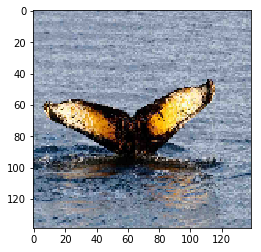

In [17]:
#Displaying image of desired index

plt.imshow(X[9])

In [18]:
print("The number of unique whale ID's : ", len(data['Id'].unique()))
data['Id'].value_counts()[:100]

The number of unique whale ID's :  4251


new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
w_fd1cb9d     22
w_ab4cae2     22
w_693c9ee     22
w_43be268     21
w_73d5489     21
w_987a36f     21
w_f19faeb     20
w_9b401eb     19
w_95874a5     19
w_b7d5069     18
w_c0d494d     18
w_0e737d0     17
w_eb0a6ed     17
w_18eee6e     17
w_dbda0d6     17
w_a59905f     16
w_67de30b     16
w_6c803bf     16
w_17ee910     16
w_b0e05b1     16
w_9ca943b     15
w_89e159a     15
w_cae7677     15
w_ee17a08     15
w_540fd73     14
            ... 
w_fa32440      9
w_8d83172      9
w_64f3545      9
w_d663f4f      9
w_b4732ef      9
w_d9aab0a      9
w_fea7fe6      9
w_813c5be      9
w_ace8c54      9
w_8867074      9
w_1a5e7a2      9
w_3af4e73      9
w_c30959a      9
w_656afeb      9
w_d88328d      9
w_861cc1c      9
w_59eb8ae      9
w_13c6b6b      8
w_d9adb4f      8
w_40323ac      8
w_9875c12      8
w_778ee6e      8
w_21e178f      8
w_2fe43c7      8
w_f81c626      8
w_c00534d      8
w_b96d4e0      8
w_9ceb05d     

In [19]:
#Label encoding and One Hot Encoding for the training labels
lenc=LabelEncoder()
oenc=OneHotEncoder()
ly=lenc.fit_transform(data['Id']).reshape((-1,1))
y=pd.get_dummies(ly[:,0])

In [20]:
#Since the training data is pretty less, we will use data augmentation to generate more data

print("The shape corresponds to (m,nh,nw,nc) : ", X.shape)
print("Number of training examples = ",X.shape[0])

X = X.reshape((-1,139,139,3))
input_shape = X[0].shape
X_train = X.astype("float32")
y_train = np.array(y)

Gen = ImageDataGenerator(
    
    rescale=1./255,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True)

#Fitting the ImageDataGenerater
Gen.fit(X_train, augment=True)

The shape corresponds to (m,nh,nw,nc) :  (9850, 139, 139, 3)
Number of training examples =  9850


### Now, we will create the model to be fitted on the training set. We will be using some Convolutional, Maxpooling and Inception blocks for this

<img src="files/basic_inception_model.png">

The above image shows a basic inception block which follows the "do all" approach. Different filter sizes are used for Convolution and a MaxPooling layer is also used. The outputs from al these are stacked to portray as a single layer result

In [27]:
def InceptionModel():
    
    model=Sequential()
    
#    model.add(InceptionV3(weights='imagenet', include_top=True,input_shape=input_shape))
    
    model.add(Conv2D(50,kernel_size=(3,3),strides=1,activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(50,kernel_size=(3,3),strides=1,activation='relu'))
    model.add(MaxPooling2D(pool_size=(6,6)))
    
    model.add(Conv2D(50,kernel_size=(3,3),strides=1,activation='relu'))
    model.add(MaxPooling2D(pool_size=(6,6)))
    
    model.add(Flatten())
    model.add(Dense(4251,activation='softmax'))
    return model

In [28]:
inception=InceptionModel()

inception.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

inception.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_289 (Conv2D)          (None, 137, 137, 50)      1400      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 68, 68, 50)        0         
_________________________________________________________________
conv2d_290 (Conv2D)          (None, 66, 66, 50)        22550     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 11, 11, 50)        0         
_________________________________________________________________
conv2d_291 (Conv2D)          (None, 9, 9, 50)          22550     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 1, 1, 50)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 50)                0         
__________

In [59]:
batch_size=15
epochs=5

inception.fit_generator(Gen.flow(X_train, y_train, batch_size=batch_size),
          steps_per_epoch= X_train.shape[0]//batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/5
656/656 [==============================] - 64s 98ms/step - loss: 8.1669 - acc: 0.0818
Epoch 2/5
656/656 [==============================] - 66s 101ms/step - loss: 7.8011 - acc: 0.0822
Epoch 3/5
656/656 [==============================] - 63s 95ms/step - loss: 7.7367 - acc: 0.0824
Epoch 4/5
656/656 [==============================] - 52s 79ms/step - loss: 7.7177 - acc: 0.0822
Epoch 5/5
656/656 [==============================] - 51s 77ms/step - loss: 7.6684 - acc: 0.0824
